In [129]:
import cv2
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import easyocr
from PIL import Image, ImageEnhance
import numpy as np

In [252]:
def preprocess_image(image_path):   

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Calculate the new dimensions
    new_height = int(height * 2)
    new_width = int(width * 2)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))


    pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    
    enhancer = ImageEnhance.Contrast(pil_image)
    contrast_img = enhancer.enhance(1.5)

    enhancer = ImageEnhance.Brightness(contrast_img)
    bright_img = enhancer.enhance(1.2)

    sharper = ImageEnhance.Sharpness(bright_img)
    sharper_img = sharper.enhance(2)

    enhanced_image = cv2.cvtColor(np.array(sharper_img), cv2.COLOR_RGB2BGR)
    
    gray = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    blurred = cv2.GaussianBlur(binary, (5, 5), 0)


    unsharp_mask = cv2.addWeighted(gray, 2, blurred, -1, 0)
    
    return unsharp_mask


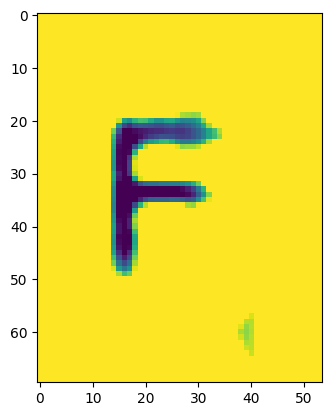

In [253]:

path = r'C:\Users\pc\Desktop\lp BigData\s6\cropped_3.jpg'

img = preprocess_image(path)
plt.imshow(img)

Using CPU. Note: This module is much faster with a GPU.


[[[[10, 16], [36, 16], [36, 50], [10, 50]], 'F']]


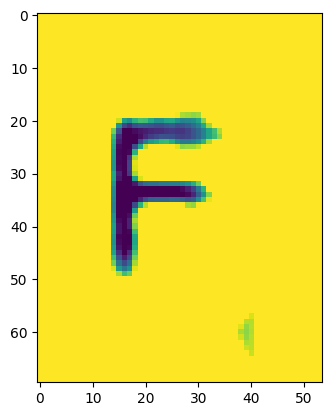

In [254]:

reader = easyocr.Reader(['fr'], gpu=False) 
res = reader.readtext(img, paragraph=True)

plt.imshow(img)
print(res)

In [255]:
import pytesseract

In [256]:

img = Image.open(path)
# img = preprocess_image(path)

text = pytesseract.image_to_string(img)
    
print(text)